In [ ]:
# =========================================
# Full Fashion-MNIST Workflow: ANN vs CNN
# =========================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# -------------------------------
# 1. Device setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# -------------------------------
# 2. Data Handling
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class labels
classes = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.90MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 136kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.45MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.0MB/s]


In [ ]:
# -------------------------------
# 3. Model Definitions
# -------------------------------
# 3A. ANN (MLP)
class FashionMNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# 3B. CNN
class FashionMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*7*7, 128)  # after 2 poolings
        self.fc2 = nn.Linear(128,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))  # 28->14
        x = self.pool(F.relu(self.conv2(x)))  # 14->7
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# -------------------------------
# 4. Training Function
# -------------------------------
def train_model(model, train_loader, val_loader, epochs=5, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, correct, total = 0,0,0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs,1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss/len(train_loader)
        train_acc = correct/total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0,0,0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs,1)
                correct_val += (preds==labels).sum().item()
                total_val += labels.size(0)
        val_loss /= len(val_loader)
        val_acc = correct_val/total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# -------------------------------
# 5. Evaluation Function
# -------------------------------
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [],[]
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs,1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm, all_preds, all_labels

In [ ]:
# -------------------------------
# 6. Train and Evaluate MLP
# -------------------------------
print("\n================ Training MLP =================")
mlp_model, mlp_train_losses, mlp_val_losses, mlp_train_accs, mlp_val_accs = train_model(FashionMNIST_MLP(), train_loader, val_loader, epochs=5)
mlp_acc, mlp_cm, mlp_preds, mlp_labels = evaluate_model(mlp_model, test_loader)
print(f"\nMLP (ANN) Test Accuracy: {mlp_acc*100:.2f}%")

# Confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=classes, yticklabels=classes)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


================ Training MLP =================
Epoch [1/5] - Train Loss: 0.5172, Train Acc: 81.10% | Val Loss: 0.3925, Val Acc: 85.82%
Epoch [2/5] - Train Loss: 0.3803, Train Acc: 86.06% | Val Loss: 0.3513, Val Acc: 86.82%
Epoch [3/5] - Train Loss: 0.3392, Train Acc: 87.45% | Val Loss: 0.3576, Val Acc: 86.61%
Epoch [4/5] - Train Loss: 0.3114, Train Acc: 88.39% | Val Loss: 0.3279, Val Acc: 88.10%
Epoch [5/5] - Train Loss: 0.2915, Train Acc: 89.19% | Val Loss: 0.3263, Val Acc: 88.07%

MLP (ANN) Test Accuracy: 87.25%



================ Training CNN =================
Epoch [1/5] - Train Loss: 0.5976, Train Acc: 78.34% | Val Loss: 0.3426, Val Acc: 87.55%
Epoch [2/5] - Train Loss: 0.3878, Train Acc: 86.10% | Val Loss: 0.2934, Val Acc: 89.18%
Epoch [3/5] - Train Loss: 0.3321, Train Acc: 88.21% | Val Loss: 0.2672, Val Acc: 90.33%
Epoch [4/5] - Train Loss: 0.2951, Train Acc: 89.31% | Val Loss: 0.2430, Val Acc: 91.33%
Epoch [5/5] - Train Loss: 0.2666, Train Acc: 90.38% | Val Loss: 0.2300, Val Acc: 91.77%

CNN Test Accuracy: 90.85%


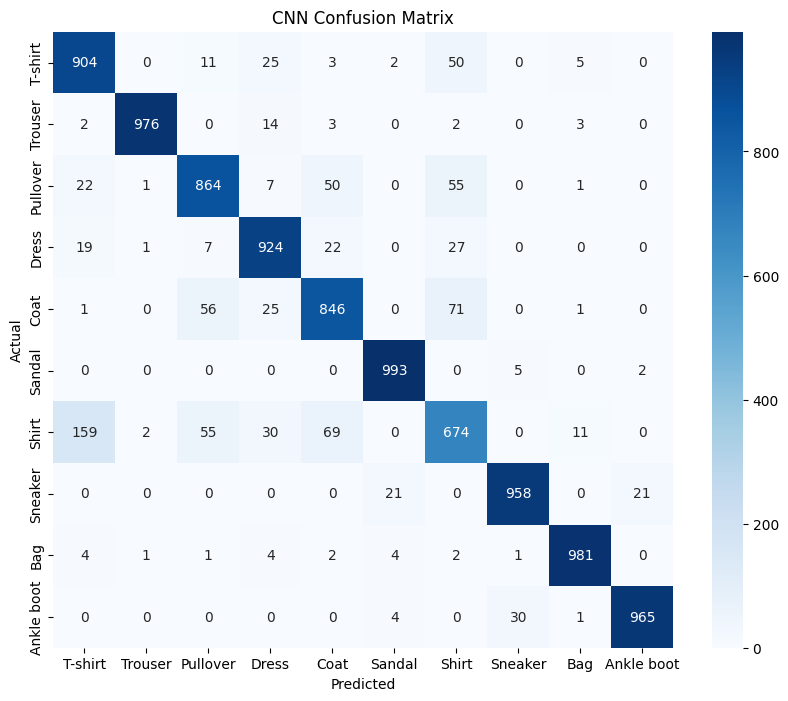

In [ ]:
# -------------------------------
# 7. Train and Evaluate CNN
# -------------------------------
print("\n================ Training CNN =================")
cnn_model, cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = train_model(FashionMNIST_CNN(), train_loader, val_loader, epochs=5)
cnn_acc, cnn_cm, cnn_preds, cnn_labels = evaluate_model(cnn_model, test_loader)
print(f"\nCNN Test Accuracy: {cnn_acc*100:.2f}%")

plt.figure(figsize=(10,8))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

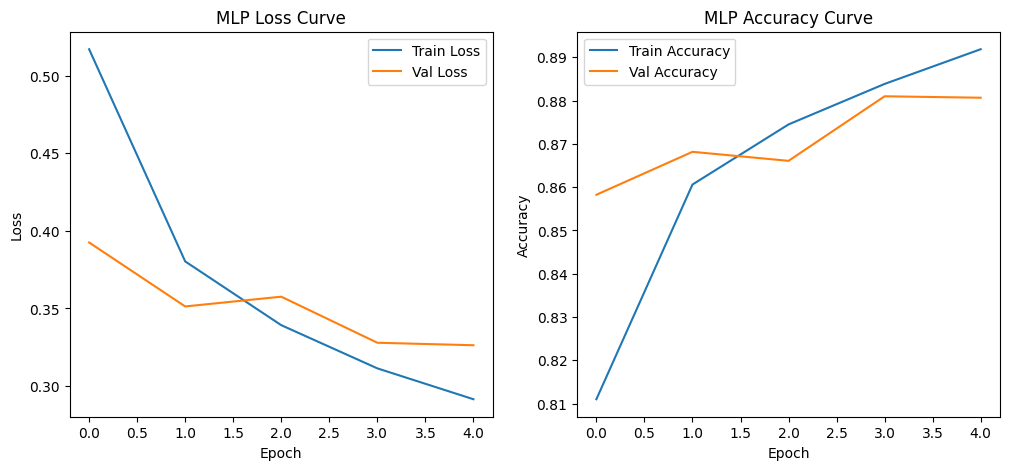

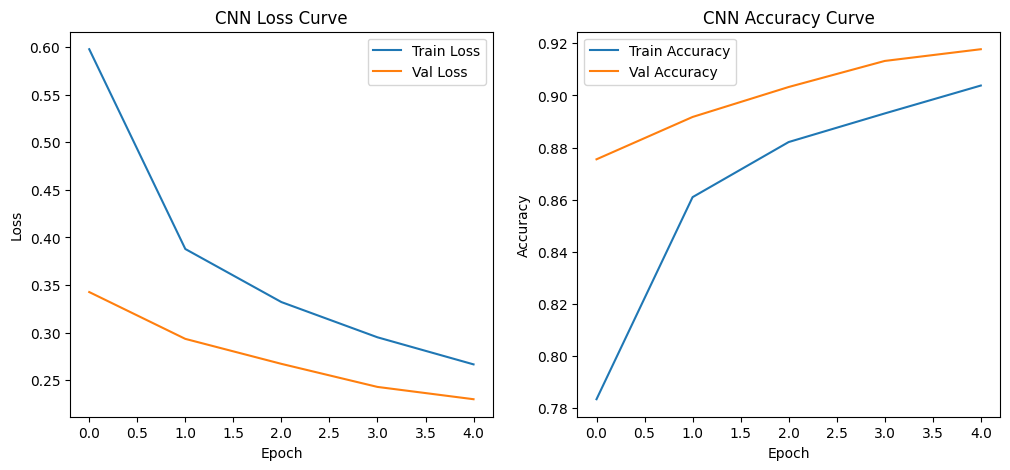

In [ ]:
# -------------------------------
# 8A. Plot Loss and Accuracy for MLP
# -------------------------------
plt.figure(figsize=(12,5))

# MLP Loss
plt.subplot(1,2,1)
plt.plot(mlp_train_losses, label='Train Loss')
plt.plot(mlp_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Loss Curve')
plt.legend()

# MLP Accuracy
plt.subplot(1,2,2)
plt.plot(mlp_train_accs, label='Train Accuracy')
plt.plot(mlp_val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP Accuracy Curve')
plt.legend()

plt.show()

# -------------------------------
# 8B. Plot Loss and Accuracy for CNN
# -------------------------------
plt.figure(figsize=(12,5))

# CNN Loss
plt.subplot(1,2,1)
plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Loss Curve')
plt.legend()

# CNN Accuracy
plt.subplot(1,2,2)
plt.plot(cnn_train_accs, label='Train Accuracy')
plt.plot(cnn_val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy Curve')
plt.legend()

plt.show()

In [ ]:
# -------------------------------
# 9. Class-wise Accuracy
# -------------------------------
print("\nClass-wise Accuracy (MLP):")
mlp_class_acc = mlp_cm.diagonal()/mlp_cm.sum(axis=1)
for idx, c in enumerate(classes):
    print(f"{c}: {mlp_class_acc[idx]*100:.2f}%")

print("\nClass-wise Accuracy (CNN):")
cnn_class_acc = cnn_cm.diagonal()/cnn_cm.sum(axis=1)
for idx, c in enumerate(classes):
    print(f"{c}: {cnn_class_acc[idx]*100:.2f}%")


Class-wise Accuracy (MLP):
T-shirt: 84.70%
Trouser: 96.60%
Pullover: 74.60%
Dress: 91.90%
Coat: 79.50%
Sandal: 93.00%
Shirt: 66.10%
Sneaker: 97.80%
Bag: 96.50%
Ankle boot: 91.80%

Class-wise Accuracy (CNN):
T-shirt: 90.40%
Trouser: 97.60%
Pullover: 86.40%
Dress: 92.40%
Coat: 84.60%
Sandal: 99.30%
Shirt: 67.40%
Sneaker: 95.80%
Bag: 98.10%
Ankle boot: 96.50%


In [ ]:
# -------------------------------
# 10. Misclassification Analysis: Visually Similar Classes
# -------------------------------
similar_pairs = [('T-shirt','Shirt'), ('Pullover','Coat'), ('Sandal','Ankle boot')]

print("\nMisclassification Analysis:")
for pair in similar_pairs:
    i = classes.index(pair[0])
    j = classes.index(pair[1])
    mlp_mis = mlp_cm[i,j] + mlp_cm[j,i]
    cnn_mis = cnn_cm[i,j] + cnn_cm[j,i]
    print(f"{pair[0]} ↔ {pair[1]}: MLP misclassified={mlp_mis}, CNN misclassified={cnn_mis}")


Misclassification Analysis:
T-shirt ↔ Shirt: MLP misclassified=243, CNN misclassified=209
Pullover ↔ Coat: MLP misclassified=186, CNN misclassified=106
Sandal ↔ Ankle boot: MLP misclassified=30, CNN misclassified=6


In [ ]:
# -------------------------------
# 11. Accuracy Comparison
# -------------------------------
print("\n================ Accuracy Comparison =================")
print(f"MLP (ANN) Test Accuracy: {mlp_acc*100:.2f}%")
print(f"CNN Test Accuracy: {cnn_acc*100:.2f}%\n")

# Compare and give reasoning
if cnn_acc > mlp_acc:
    print("CNN outperforms MLP (ANN).")
    print("- CNN preserves spatial relationships in images through convolution and pooling.")
    print("- CNN extracts hierarchical features (edges, shapes, textures), reducing misclassification.")
    print("- MLP flattens images, losing spatial information, which causes more confusion in visually similar classes.")
else:
    print("MLP (ANN) performs similarly or better (rare case).")
    print("- This may occur if CNN is undertrained or dataset is too simple.")



================ Accuracy Comparison =================
MLP (ANN) Test Accuracy: 87.25%
CNN Test Accuracy: 90.85%

CNN outperforms MLP (ANN).
- CNN preserves spatial relationships in images through convolution and pooling.
- CNN extracts hierarchical features (edges, shapes, textures), reducing misclassification.
- MLP flattens images, losing spatial information, which causes more confusion in visually similar classes.


In [14]:
# =======================
# 1. Imports
# =======================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cpu


In [15]:
# =======================
# 2. Data Handling
# =======================
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=test_transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

classes = ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]


In [16]:
# =======================
# 3. Models
# =======================

# Improved MLP (ANN)
class FashionMNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

# Improved CNN
class FashionMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 256), nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


In [23]:
# =======================
# 4. Training Function
# =======================
def train_model(model, train_loader, val_loader, epochs=5):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total, correct, train_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct += (preds.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)
        train_acc = correct/total

        # Validation
        model.eval()
        val_loss, vcorrect, vtotal = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                preds = model(images)
                val_loss += criterion(preds, labels).item()
                vcorrect += (preds.argmax(dim=1) == labels).sum().item()
                vtotal += labels.size(0)
        val_acc = vcorrect/vtotal

        scheduler.step()

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return model, train_losses, val_losses, train_accs, val_accs


In [24]:
# =======================
# 5. Train Models
# =======================
print("\nTraining ANN (MLP)...")
mlp_model, mlp_train_losses, mlp_val_losses, mlp_train_accs, mlp_val_accs = train_model(FashionMNIST_MLP(), train_loader, val_loader)

print("\nTraining CNN...")
cnn_model, cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = train_model(FashionMNIST_CNN(), train_loader, val_loader)



Training ANN (MLP)...
Epoch 1/5 | Train Acc: 0.7884 | Val Acc: 0.8286
Epoch 2/5 | Train Acc: 0.8384 | Val Acc: 0.8482
Epoch 3/5 | Train Acc: 0.8580 | Val Acc: 0.8630
Epoch 4/5 | Train Acc: 0.8709 | Val Acc: 0.8693
Epoch 5/5 | Train Acc: 0.8810 | Val Acc: 0.8792

Training CNN...
Epoch 1/5 | Train Acc: 0.8199 | Val Acc: 0.8813
Epoch 2/5 | Train Acc: 0.8875 | Val Acc: 0.9022
Epoch 3/5 | Train Acc: 0.9083 | Val Acc: 0.9131
Epoch 4/5 | Train Acc: 0.9222 | Val Acc: 0.9223
Epoch 5/5 | Train Acc: 0.9307 | Val Acc: 0.9224


In [25]:
# =======================
# 6. Evaluate
# =======================
def evaluate(model):
    model.eval()
    preds_list, true_list = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            preds = model(images).argmax(dim=1).cpu()
            preds_list.extend(preds)
            true_list.extend(labels)
    preds_list, true_list = np.array(preds_list), np.array(true_list)
    acc = (preds_list == true_list).mean()
    cm = confusion_matrix(true_list, preds_list)
    return acc, cm

mlp_acc, mlp_cm = evaluate(mlp_model)
cnn_acc, cnn_cm = evaluate(cnn_model)

print(f"\nMLP Test Accuracy: {mlp_acc*100:.2f}%")
print(f"CNN Test Accuracy: {cnn_acc*100:.2f}%")



MLP Test Accuracy: 87.76%
CNN Test Accuracy: 92.34%


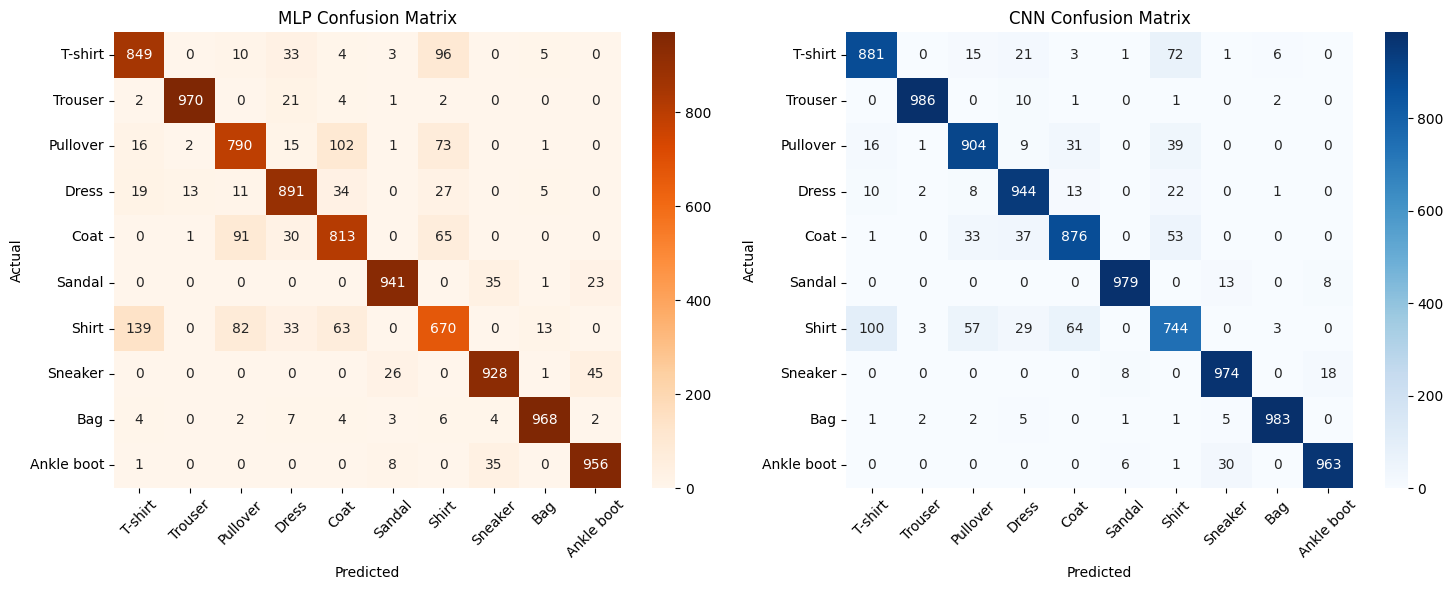

In [33]:
# =======================
# 7. Confusion Matrices (With Values)
# =======================
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap="Oranges")
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(len(classes))+0.5, classes, rotation=45)
plt.yticks(np.arange(len(classes))+0.5, classes, rotation=0)

plt.subplot(1,2,2)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap="Blues")
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(len(classes))+0.5, classes, rotation=45)
plt.yticks(np.arange(len(classes))+0.5, classes, rotation=0)

plt.tight_layout()
plt.show()


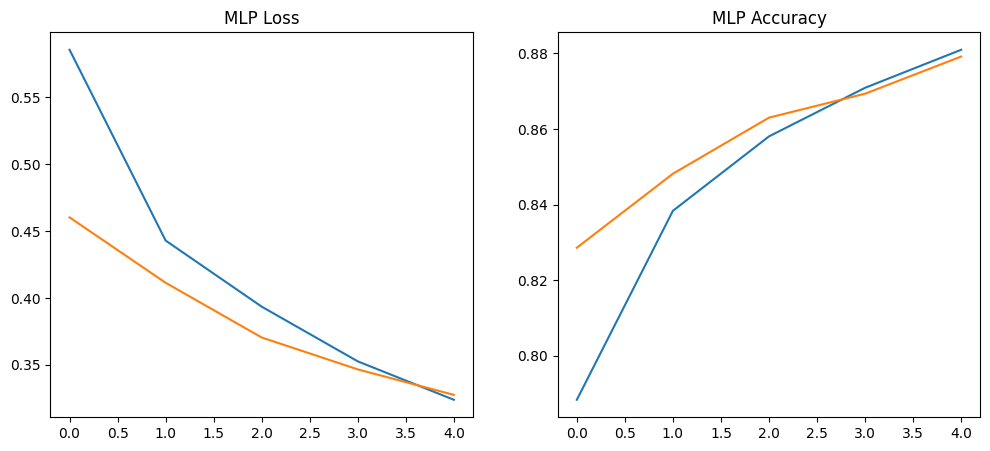

In [34]:
# =======================
# 8. Loss & Accuracy Curves
# =======================
def plot_curves(train_l, val_l, train_a, val_a, name):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_l); plt.plot(val_l); plt.title(name+" Loss")
    plt.subplot(1,2,2); plt.plot(train_a); plt.plot(val_a); plt.title(name+" Accuracy")
    plt.show()

plot_curves(mlp_train_losses, mlp_val_losses, mlp_train_accs, mlp_val_accs, "MLP")
plot_curves(cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs, "CNN")

In [35]:
# =======================
# 9. Class-wise Accuracy
# =======================
print("\nClass-wise Accuracy (MLP):")
mlp_class_acc = mlp_cm.diagonal()/mlp_cm.sum(axis=1)
for i, c in enumerate(classes):
    print(f"{c}: {mlp_class_acc[i]*100:.2f}%")

print("\nClass-wise Accuracy (CNN):")
cnn_class_acc = cnn_cm.diagonal()/cnn_cm.sum(axis=1)
for i, c in enumerate(classes):
    print(f"{c}: {cnn_class_acc[i]*100:.2f}%")


Class-wise Accuracy (MLP):
T-shirt: 84.90%
Trouser: 97.00%
Pullover: 79.00%
Dress: 89.10%
Coat: 81.30%
Sandal: 94.10%
Shirt: 67.00%
Sneaker: 92.80%
Bag: 96.80%
Ankle boot: 95.60%

Class-wise Accuracy (CNN):
T-shirt: 88.10%
Trouser: 98.60%
Pullover: 90.40%
Dress: 94.40%
Coat: 87.60%
Sandal: 97.90%
Shirt: 74.40%
Sneaker: 97.40%
Bag: 98.30%
Ankle boot: 96.30%


In [36]:
# =======================
# 10. Misclassification Analysis
# =======================
pairs = [("T-shirt","Shirt"),("Pullover","Coat"),("Sandal","Ankle boot")]
print("\nMisclassification Between Visually Similar Classes:")
for p in pairs:
    i, j = classes.index(p[0]), classes.index(p[1])
    print(f"{p[0]} ↔ {p[1]}: ANN={mlp_cm[i,j]+mlp_cm[j,i]}, CNN={cnn_cm[i,j]+cnn_cm[j,i]}")


Misclassification Between Visually Similar Classes:
T-shirt ↔ Shirt: ANN=235, CNN=172
Pullover ↔ Coat: ANN=193, CNN=64
Sandal ↔ Ankle boot: ANN=31, CNN=14


In [37]:
# =======================
# 11. Final Comparison & Reason
# =======================
print("\n===== FINAL COMPARISON =====")
print(f"MLP (ANN) Accuracy: {mlp_acc*100:.2f}%")
print(f"CNN Accuracy: {cnn_acc*100:.2f}%")

print("\nConclusion:")
print("- CNN clearly outperforms ANN because CNN preserves spatial structure in images.")
print("- ANN flattens the image, losing important shape and texture features.")
print("- CNN learns edges → patterns → clothing textures, improving classification of similar classes like Coat vs Pullover and Shirt vs T-shirt.")


===== FINAL COMPARISON =====
MLP (ANN) Accuracy: 87.76%
CNN Accuracy: 92.34%

Conclusion:
- CNN clearly outperforms ANN because CNN preserves spatial structure in images.
- ANN flattens the image, losing important shape and texture features.
- CNN learns edges → patterns → clothing textures, improving classification of similar classes like Coat vs Pullover and Shirt vs T-shirt.
